# DSCI 100 Project Final: Predicting Subscription Status of a Player from Age and Game Play Time

A research group in Computer Science at UBC investigates how people play video games. In this case, they took efforts to set up a MineCraft server that links to an external site, and players' actions are recorded as they navigate through the world. 
Here, subscription status of the player is pertinent information in understanding which demographics to target for promotions, recruitment and ensuring enough resources are wisely distributed for these portions.

In this project, the question, “Can a player's hours played, and age predict if the player is subscribed to the newsletter in the data set, players.csv" is explored by the variables Age, player_hours and subscription. 

#### Data set
Quantitative/Numerical Variables:
Age (Age, int): Age of the player in years (. The lowest is 8 years old and highest 99 years old. Data possibly derived from their registration profile.

played_hours num or dbl): The hours the player has spent on the platform in their total gameplay (range from 0-223.1 hours). Determines how engaged and commited the player is to the game.

Categorical Variables:
experiance (chr): Skill level of the player (Beginner, Amateur, Regular, Veteran, Pro) either self-reported or assigned. “Beginner” being least skillful, “Pro” very skillful.

subscription (lgl): Indicates whether the player is subscribed (TRUE) or not subscribed (FALSE) to the mailing list.

hashedEmail (chr): hash of player’s email address. Included in the database to send emails if subscribed or other communication if necessary to the player.

name (chr): Name of the player, self-reported or self-chosen. A username or real legal name.

gender (chr): Gender of the player, either “male”, “female”, “agender”, “two-spirited”, “prefer not to say”, “non-binary”, “other”. Self-reported data in their profiles.

#### Methodology

*K Nearest Neighbours Classification will be used as there are two numerical predictor variables (binary) to predict a qualitative variable. Age and playtime will be neighbours in predicting subscription habits will be analyzed.*

1. Selecting and Wrangling: The Age, player_hours and subscription will be selected–using select()–and derived from players.csv. From there, any NA values will be filtered out, specifically for Age. Then, critical outliers will be filtered out for both quantitative variables. Age will filter out any ages 40+ years old and played_time will filter out any inactivity (0 hours) along with outliers, to exclude 30+hours. Once these have been completed, the data can be better displayed to explore the relationship between age, hours played, and subscription status to answer the predictive question.
2. Split the data: The data will be shuffled, stratified and then split into training (70%) and test (30%) sets at the beginning of the process, using initial_split(). In building and training the classifier, standardization of age and player hours will take place.
3. Tune for K: The training set will further be split into 5 chunks for cross validation, with 1 validation set and 4 training subsets in each fold, use vfold_cv(). From there, tune_grid() will be used to fit the model for each value in a range of parameter values (1-100, by = 5 intervals). The accuracies of K values will be analyzed both computationally and visually (plot) and the highest accuracy (peak) will be selected as the K value used in this model.
4. Evaluate Model Performance: A confusion matrix along with accuracy, precision and recall will be utilized in the selection of a model. The “positve” class is those who are subscribed (subscribe = TRUE) and “negative” (subscribe = FALSE)

In [ ]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")

In [2]:
#loading the players' data set
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57


### 1. Select and Wrangle Data

In [17]:
#wrangling the data into more applicable use for this project
players_data <- players |>
    select(subscribe, played_hours, Age)|> #selecting only columns we need for this project, subscribe, played_hours, Age
    filter(Age <= 40, played_hours < 30, played_hours > 0)|> #removing outliers for Age and played_hours to prevent inflation of results, removing all inactive players (played_hours >0)
    mutate(subscribe = factor(subscribe, levels = c(TRUE, FALSE), labels = c("true", "false")))  #changing all logical to factors so that classification method can be done
players_data

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
true,3.8,17
true,0.7,21
true,0.1,21
true,1.6,23
true,1.5,25
⋮,⋮,⋮
false,0.2,17
false,1.7,17
false,0.1,18


#### 1a. Summary Statistics of Data

In [18]:
#summary statistics of the data (quantative), once it has been wrangled
summary_table <- players_data |>
    summarize(mean_played_hours = mean(played_hours, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE), median_played_hours = median(played_hours, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE), sd_played_hours = sd(played_hours, na.rm = TRUE),
    sd_age = sd(Age, na.rm = TRUE))

summary_table

minmax_table <- players_data |>
    summarize(max_played_hours = max(played_hours, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE), min_played_hours = min(played_hours, na.rm = TRUE),
    min_age = min(Age, na.rm = TRUE))

minmax_table 

mean_played_hours,mean_age,median_played_hours,median_age,sd_played_hours,sd_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.434737,20.2,0.4,19,3.316361,4.741398


max_played_hours,max_age,min_played_hours,min_age
<dbl>,<dbl>,<dbl>,<dbl>
23.7,38,0.1,10


#### 1b. Additional Visualizations

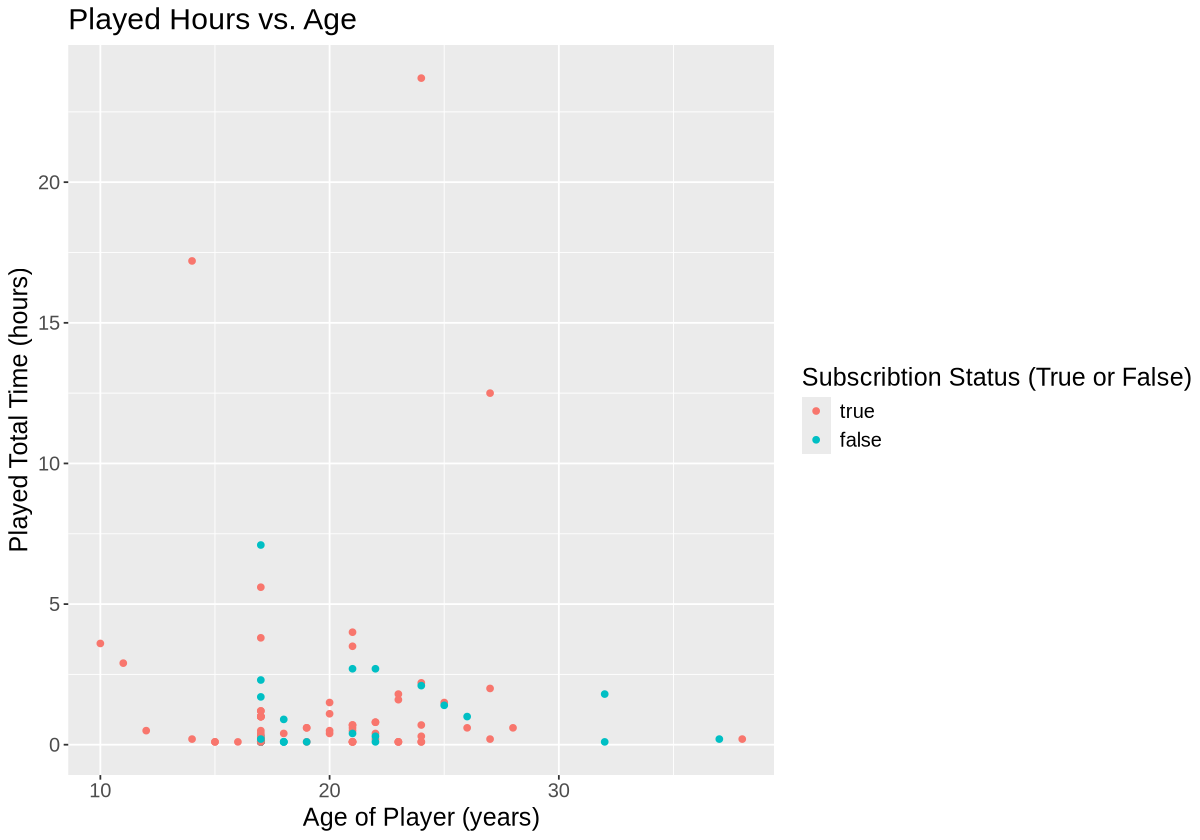

In [19]:
#visualization of the data
options(repr.plot.height = 7, repr.plot.width = 10)
players_plot <- players_data|>
    ggplot(aes(x=Age, y=played_hours, color=subscribe))+
    geom_point()+
    labs(x="Age of Player (years)", y="Played Total Time (hours)", color="Subscribtion Status (True or False)")+
    ggtitle("Played Hours vs. Age")+
    theme(text = element_text(size = 15))
players_plot

#### Figure 1
This is the visualization of the exploratory portion of the question "Can a player's hours played, and age predict the players subscription state?". There is no strong correlation (positive or negative) in the relationship between played hours and age of player (Ie. increase of age does not seem to increase the hours played in the game). The total playtime is generally stagnat around 0-5 hours (not including 0 as those are inactive players) across all ages 10-40 years old. The players are more populated around ages 11-28years old. The subscription pattern seems to increase upon increase in age (above around 17) and increase in game play (more "true" subscription, as the played time increases, highest values have all "true" values

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


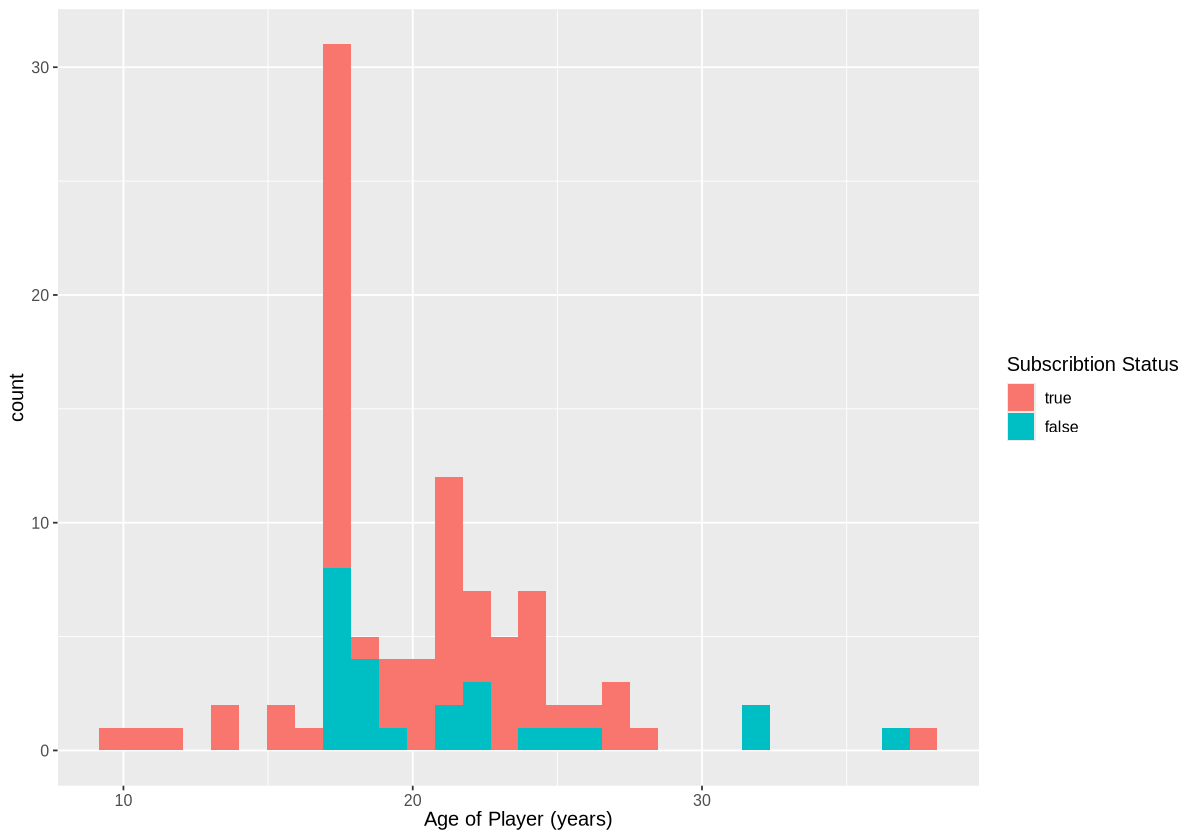

In [20]:
options(repr.plot.height = 7, repr.plot.width = 10)
age_distribution <- players_data|>
    ggplot(aes(x=Age, fill = subscribe))+
    geom_histogram() +
    labs(x = "Age of Player (years)", fill = "Subscribtion Status") +
    theme(text = element_text(size = 12))
age_distribution

#### Figure 2
This is the visualization of the distribution of age in the data set players.csv. It could have followed a bell curve, however there is a disproportional peak at age = 17, showing that there is a clear sample bias and this data is not as representative of the general population.

Warning message in geom_histogram(bindwidth = 10):
“Ignoring unknown parameters: `bindwidth`”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


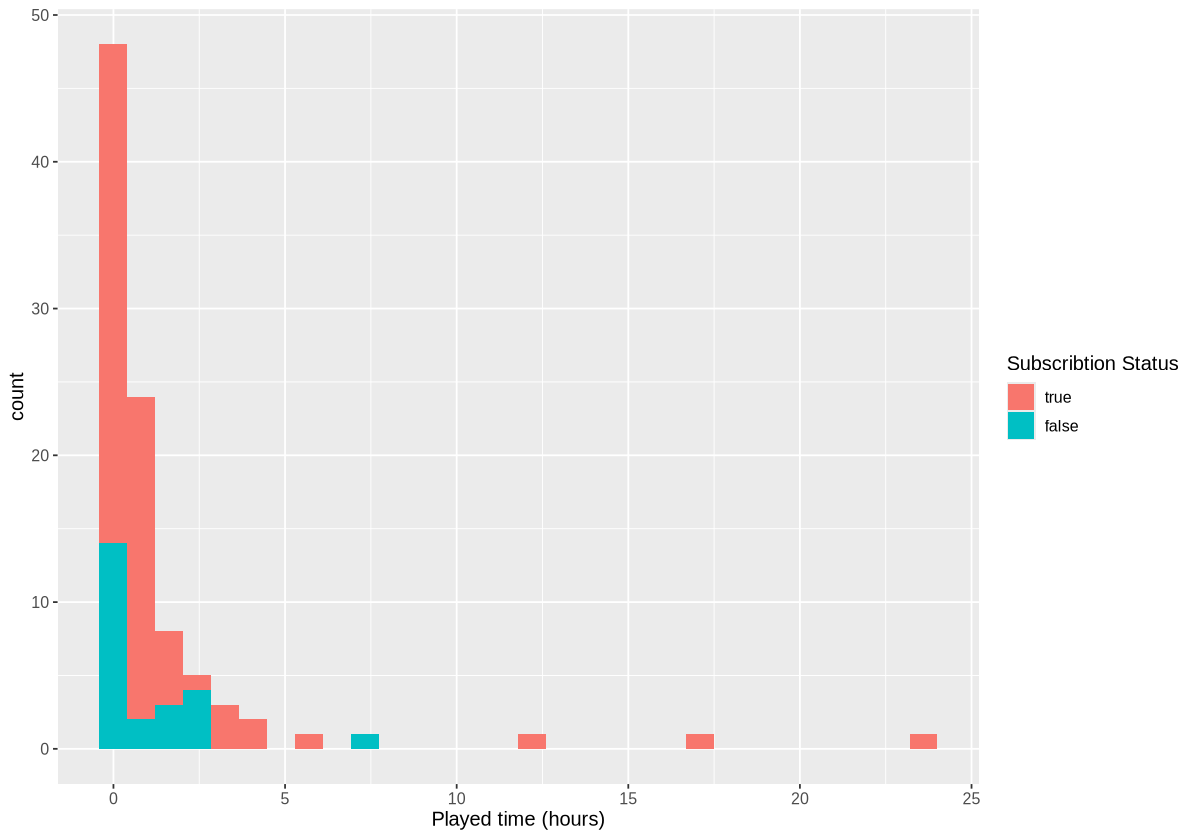

In [21]:
options(repr.plot.height = 7, repr.plot.width = 10)
hours_distribution <- players_data|>
    ggplot(aes(x=played_hours, fill = subscribe))+
    geom_histogram(bindwidth = 10) +
    labs(x = "Played time (hours)", fill = "Subscribtion Status") +
    theme(text = element_text(size = 12))
hours_distribution

#### Figure 3
Playtime data is heavily right-skewed peaking near but NOT AT 0 (as 0 was filtered out, inactive players) time (ie. 0.1-0.9hrs). Only few players have a playtime higher than 7hrs, which decreases as the hours length (hence why the data was filtered out after the 30 hr mark). This data indicates that the most active players only played for a small amount of time, therefore there was low engagement and more causal players.

### 2. Spliting and Stratifiying data

In [36]:
#splitting data into test and training sets, make 75% training data and 25% testing, strata is subscribe as that is the response value
data_split <- initial_split(players_data, prop = 0.7, strata = subscribe)
players_train <- training(data_split)
players_test <- testing(data_split) 

#create a recipe using the training data, preprocess and standardize the quantitative predictors
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_data) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



### 3. Tune for K– 5 fold cross validation

In [41]:
# Tune for k
set.seed(123)

folds <- vfold_cv(players_train, v=5, strata = subscribe)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

players_tune <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = folds, grid = k_vals) 

players_accuracy <- players_tune |> 
    collect_metrics() |>
    filter(.metric == "accuracy")

players_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6441392,5,0.05473985,Preprocessor1_Model01
2,accuracy,binary,0.6441392,5,0.05473985,Preprocessor1_Model02
3,accuracy,binary,0.6928571,5,0.04086302,Preprocessor1_Model03
4,accuracy,binary,0.6928571,5,0.04086302,Preprocessor1_Model04
5,accuracy,binary,0.7223443,5,0.02057161,Preprocessor1_Model05
6,accuracy,binary,0.7223443,5,0.02057161,Preprocessor1_Model06
7,accuracy,binary,0.7543956,5,0.01069666,Preprocessor1_Model07
8,accuracy,binary,0.7390110,5,0.01539442,Preprocessor1_Model08
9,accuracy,binary,0.7543956,5,0.01069666,Preprocessor1_Model09


### 3a. Choose best K value

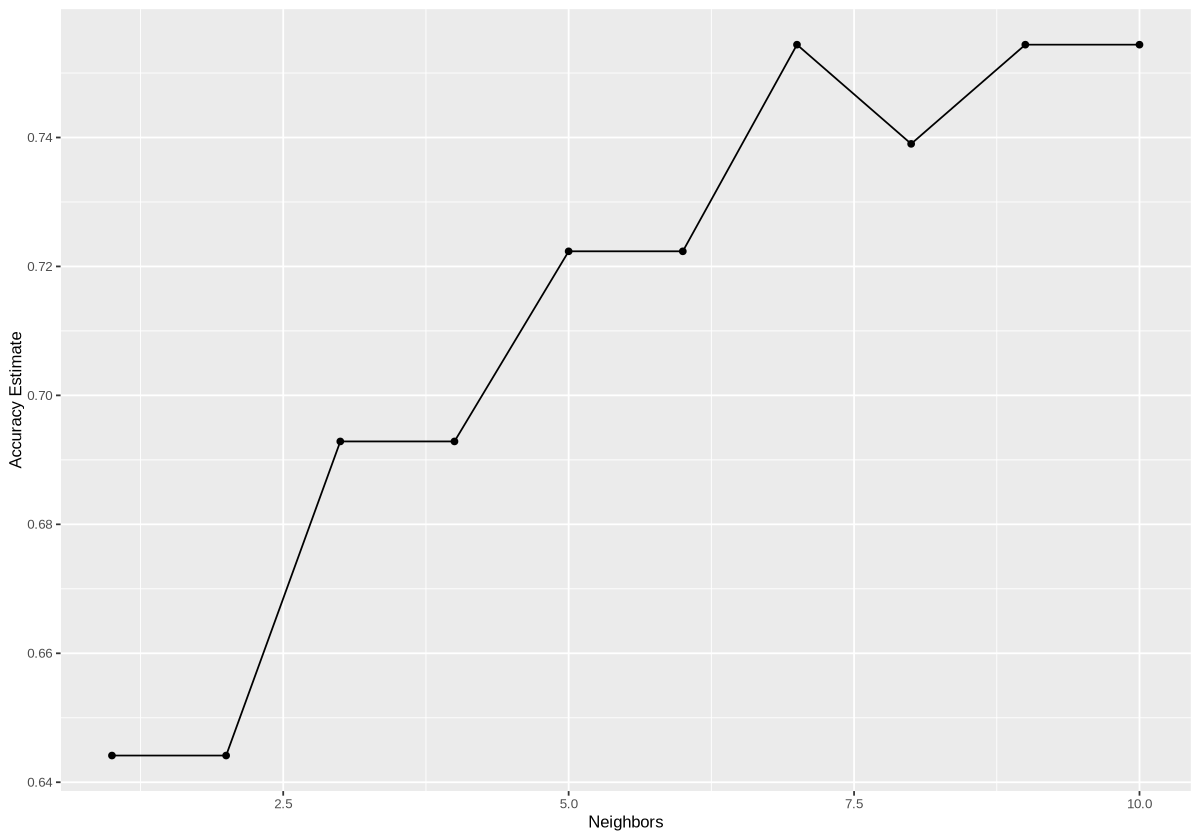

In [43]:
# Generate accuracy estimation plot to determine optimal k
accuracy_vs_k <- ggplot(players_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 10))

accuracy_vs_k

#### Figure 4
From this graph we can see that the accuracy of K peaks at K=7, showing that this amount of neighbours, through a qualitative analysis will be the best K value

In [46]:
#quantative analysis of selecting best K value based on optimal accuracy
best_k <- players_accuracy |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

[1] 7

In [50]:
#use the best k value found and evaluate the model  
players_best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> #best_k = 7
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_model) |>
    fit(data = players_train)

players_predictions <- predict(knn_results, players_test) |>
    bind_cols(players_test)

players_predictions


.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
true,true,3.8,17
true,true,0.7,21
true,true,0.1,21
true,true,1.6,23
true,false,0.1,17
⋮,⋮,⋮,⋮
true,true,0.6,19
true,true,0.5,20
true,false,1.0,26


In [53]:
#accuracy of the classifer examining
players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |> #specify truth = subscribe to see all CORRECT subscribed predictions and estimate = .pred_class for the predicted subscriptions
  filter(.metric == "accuracy")
#we have a 73% accuracy

#examine the precision and recall
players_predictions |> pull(subscribe) |> levels() #look at the levels of the players

#true is the first level, so indicate this when looking at precision
players_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "first")
#we have 73% precision

#look at recall with the same indicated "true" as the first level
players_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")
#we have 100% recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7333333


[1] "true"  "false"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7333333


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


In [54]:
confusion <- players_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction true false
     true    22     8
     false    0     0

### Summarize what you found

After cleaning up the data, we ended up with 95 players and most of them barely played the game at all. When we graphed age and hours played, the subscribed and unsubscribed players were mixed with no clear pattern (figure 1). 

Upon tuning, the usage of playtime and age in predicting subscription status in the KNN classification with 7 K neighbours resulted in an accuracy of 73% and recall of 100%, and precision of 73%. Along with this, the confusion matrix showed predicting “subscribe” for nearly all cases. This accurately derived all subscribed players which was useful in identifying all subscribers (hence the very high recall of 100% and decent accuracy 73%)  and not missing them; however, there was a failure to predict non-subscribers (precision is low 73%). This showed the model couldn’t separate the classes. Overall, age and total hours played didn’t help predict subscription.

### Is this what you expected?

It was originally thought that those who spend more time playing might be more likely to subscribe, so I expected at least a small difference. But once examining the graph and how much the two groups overlapped, it made sense why the model couldn’t learn anything useful. The tuned model didn’t improve much either which was surprising but it showed that the features we used just didn’t relate to subscription at all. Along with this, even after tuning, the model performed poorly, which was unexpected. 

### Impact of these findings

These results show that usage of only age and hours played to predict who subscribes would be inefficient and make for a poor classifier. The model ended up guessing subscribed most of the time and barely caught any unsubscribed players. This suggests that subscription potentially depends on other variables that were not measured. It also signifies that the team should think about collecting better features if they want a useful model in the future.
These findings are pertinent for the marketing strategies and efficiency of resource distributions to these subscribe. However as this classifier was rather faulty and did not accurately differentiate between subscribed/non-subscribed, this could lead to wasted resources on players that are not subscribed but falsely classified as subscribed.

### Future questions

This project raises questions about what actually affects subscription. It might be more helpful to look at how often players come back, how long their sessions usually are, what they do in the game. It would also be worth trying other models or gathering a bigger and more balanced dataset. Overall, there are many other things we could explore to understand why someone chooses to subscribe.
